# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости авто. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Основные шаги:**

- Загрузить данные.
- Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
- Подготовить выборки для обучения моделей.
- Обучить разные модели.
- Проанализировать время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

***Примечания:***
- Для оценки качества моделей применять метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.

**Описание данных:**

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

## Подготовка данных

In [1]:
# pip install --upgrade category_encoders

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import category_encoders as ce
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    df= pd.read_csv('/datasets/autos.csv', sep=',')
except:
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', sep=',')

In [4]:
def df_info(df):
    display(df.shape)
    print(100*"/")
    df.info()
    print(100*"/")
    display(df.describe())
    print(100*"/")
    display('Количетсво пропусков по каждому столбцу:', df.isna().sum())
    print(100*"/")
    display('Доля пропусков по каждому столбцу:', (round(df.isna().sum()/df.shape[0]*100, 2)).sort_values(ascending=False))
    print(100*"/")
    print('Доля строк с хотябы одним пропущенным значением:', \
          round(sum(df.apply(lambda x: sum(x.isnull().values), axis = 1)>0)/len(df)*100, 2), '%')
    print(100*"/")
    display('Количество дубликатов:', df.duplicated().sum())
    print(100*"/")

In [5]:
df_info(df)

(354369, 16)

////////////////////////////////////////////////////////////////////////////////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode     

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


////////////////////////////////////////////////////////////////////////////////////////////////////


'Количетсво пропусков по каждому столбцу:'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

////////////////////////////////////////////////////////////////////////////////////////////////////


'Доля пропусков по каждому столбцу:'

Repaired             20.08
VehicleType          10.58
FuelType              9.28
Gearbox               5.60
Model                 5.56
DateCrawled           0.00
Price                 0.00
RegistrationYear      0.00
Power                 0.00
Kilometer             0.00
RegistrationMonth     0.00
Brand                 0.00
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

////////////////////////////////////////////////////////////////////////////////////////////////////
Доля строк с хотябы одним пропущенным значением: 30.63 %
////////////////////////////////////////////////////////////////////////////////////////////////////


'Количество дубликатов:'

4

////////////////////////////////////////////////////////////////////////////////////////////////////


- В датасете присутствуют 354369 объектов, 15 признаков и 1 целевой признак price.
- более 10% пропущенных значений есть в признаках Repaired и VehicleType, до 10% - в признаках FuelType, Gearbox, Model. В остальных признаках пропусков нет.
- Доля объектов с хотябы одним пропущенным значением составляет почти 31%, что достаточно много.
- в данных присутствует 4 полных дубликата, которые необходимо удалить.

**Рассмотрим признаки:**

- ~~- DateCrawled — дата скачивания анкеты из базы~~
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- ~~- RegistrationMonth — месяц регистрации автомобиля~~
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- ~~- DateCreated — дата создания анкеты~~
- ~~- NumberOfPictures — количество фотографий автомобиля~~
- ~~- PostalCode — почтовый индекс владельца анкеты (пользователя)~~
- ~~- LastSeen — дата последней активности пользователя~~

Зачеркнутые признаки наиболее вероятно никак не влияют на рыночную стоимость автомобиля, поэтому удалим их, но позже. На этапе анализа данных эти признаки удалять не будем, а переведем их в нужный формат и изучим.

In [6]:
#сохраним в переменную len_df начальное количество объектов в датафрейме
len_df = df.shape[0]
print(len_df)

354369


In [7]:
df = df.drop_duplicates().reset_index(drop=True)

In [8]:
df.duplicated().sum()

0

In [9]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [10]:
#приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354365 non-null  datetime64[ns]
 1   price              354365 non-null  int64         
 2   vehicletype        316875 non-null  object        
 3   registrationyear   354365 non-null  int64         
 4   gearbox            334532 non-null  object        
 5   power              354365 non-null  int64         
 6   model              334660 non-null  object        
 7   kilometer          354365 non-null  int64         
 8   registrationmonth  354365 non-null  int64         
 9   fueltype           321470 non-null  object        
 10  brand              354365 non-null  object        
 11  repaired           283211 non-null  object        
 12  datecreated        354365 non-null  datetime64[ns]
 13  numberofpictures   354365 non-null  int64   

In [11]:
display('Минимальная и максимальная дата скачивания анкеты из базы:', df['datecrawled'].min(), df['datecrawled'].max())
display('Минимальная и максимальная дата создания анкеты:', df['datecreated'].min(), df['datecreated'].max())
display('Минимальная и максимальная дата последней активности пользователя:', df['lastseen'].min(), df['lastseen'].max())

'Минимальная и максимальная дата скачивания анкеты из базы:'

Timestamp('2016-03-05 14:06:22')

Timestamp('2016-04-07 14:36:58')

'Минимальная и максимальная дата создания анкеты:'

Timestamp('2014-03-10 00:00:00')

Timestamp('2016-04-07 00:00:00')

'Минимальная и максимальная дата последней активности пользователя:'

Timestamp('2016-03-05 14:15:08')

Timestamp('2016-04-07 14:58:51')

**В датасете присутствуют объявления о продаже авто созданные в период с марта 2014 года по апрель 2016 года.**

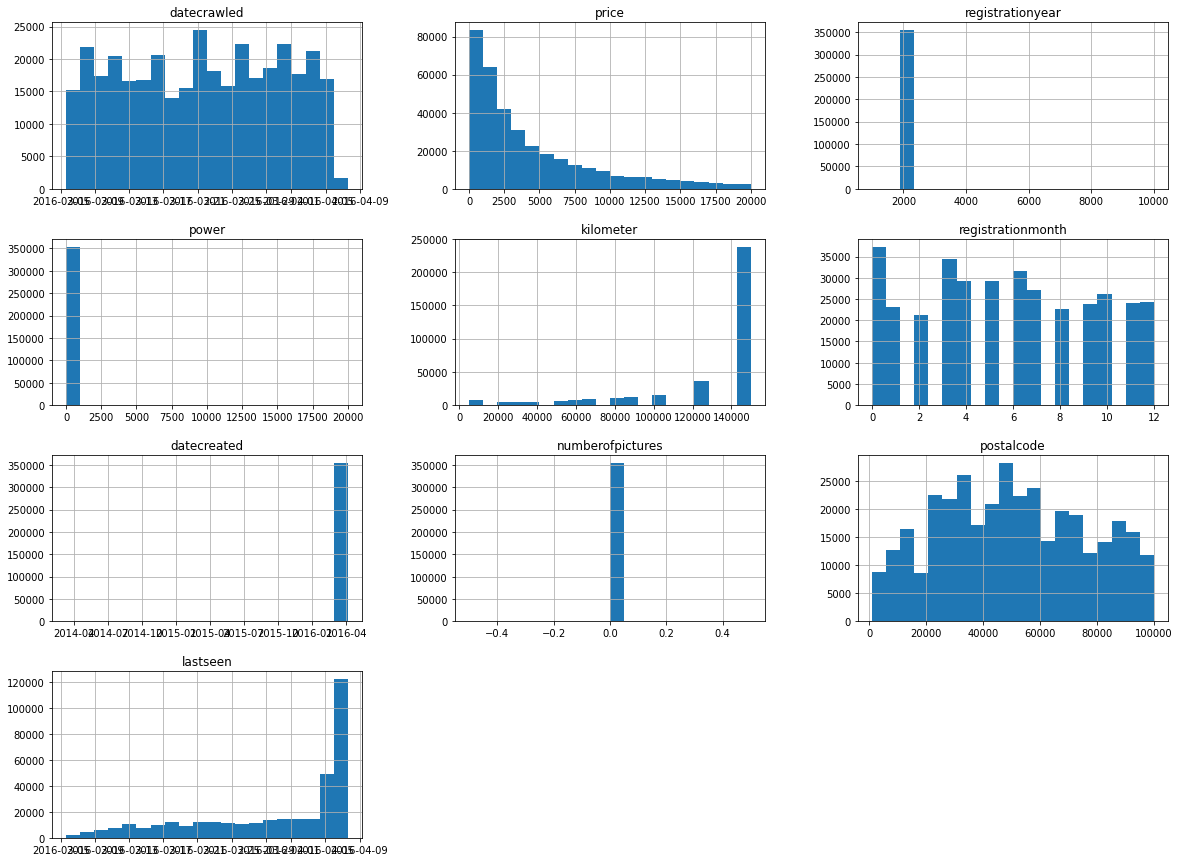

In [12]:
df.hist(figsize=(20, 15), bins=20);

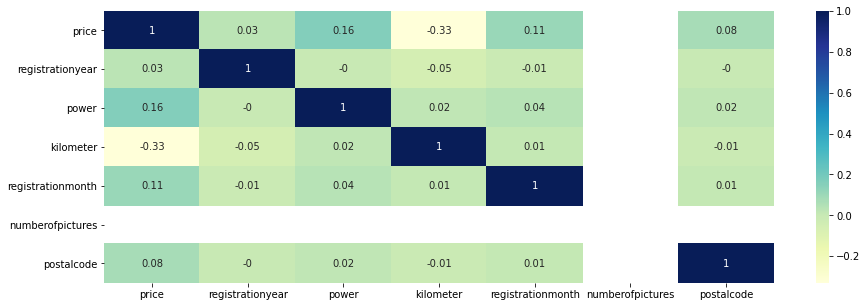

In [13]:
plt.figure(figsize=(15, 5))
sns.heatmap(df.corr().round(2), cmap="YlGnBu", annot=True)
plt.show()

**Коррелирующие признаки отсутствуют.**

In [14]:
#создадим список важных признаков
important = ['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model', \
             'kilometer', 'fueltype', 'brand', 'repaired']

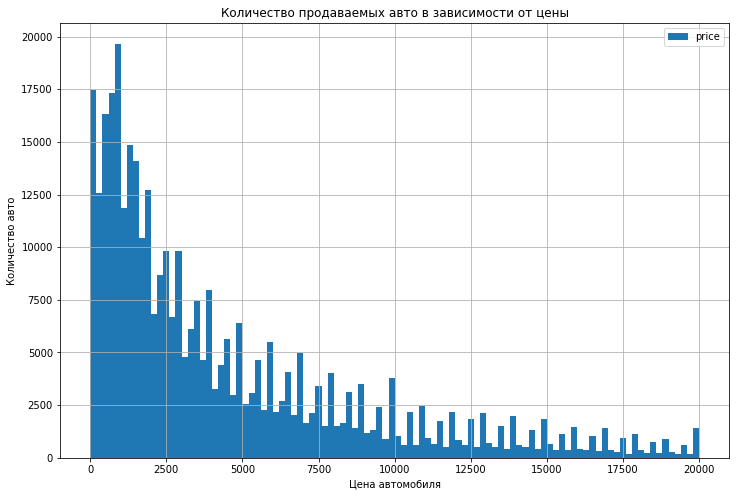

In [15]:
df.plot(y='price', kind='hist', bins=100, grid=True, figsize=(12, 8))
plt.xlabel('Цена автомобиля')
plt.ylabel('Количество авто')
plt.title("Количество продаваемых авто в зависимости от цены")
plt.show()

**Видим большое количество автомобилей с нулевой ценой.**

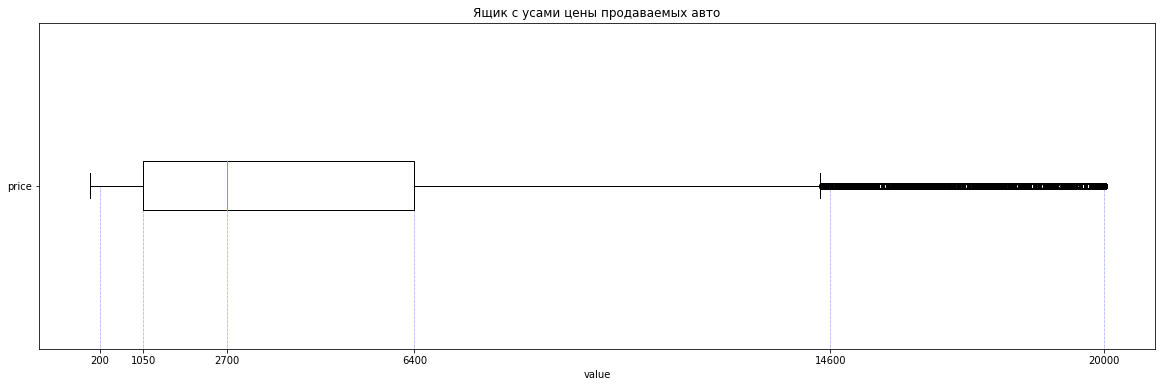

In [16]:
fig = plt.figure(1, figsize=(20, 6))
ax = fig.add_subplot(111)

ax.boxplot(df['price'], vert=False, manage_ticks=True)
ax.set_xlabel('value')
ax.set_yticks([1])
ax.set_yticklabels(['price'])

quantiles = np.quantile(df['price'], np.array([0.05, 0.25, 0.50, 0.75, 0.95, 1.00]))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(quantiles)
plt.title("Ящик с усами цены продаваемых авто")
plt.show()

**Eдалим объекты, в которых стоимость машин равно 0.**

In [17]:
print("Доля объявлений машин стоимостью 0 евро:",round(len(df.loc[df['price'] == 0])/len_df*100, 2))

Доля объявлений машин стоимостью 0 евро: 3.04


In [18]:
df = df.query('price > 0')
# df = df.query('price > 0').reset_index(drop=True)
print('Доля оставшихся данных от начального датасета:', round(df.shape[0]/len_df*100, 2))

Доля оставшихся данных от начального датасета: 96.96


**Осталось 97 % данных, что приемлемо.**

In [19]:
df.isna().sum()

datecrawled              0
price                    0
vehicletype          33750
registrationyear         0
gearbox              17355
power                    0
model                17521
kilometer                0
registrationmonth        0
fueltype             29459
brand                    0
repaired             65866
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

In [20]:
display(df['vehicletype'].unique())
df.groupby('vehicletype').agg({'vehicletype': ['count']})

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

,vehicletype
,count
vehicletype,
bus,28345
convertible,19865
coupe,15634
other,3086
sedan,89405
small,78017
suv,11791
wagon,63700


**В значениях есть тип 'other', заполним пропуски этим же значением.**

In [21]:
df['vehicletype'] = df['vehicletype'].fillna('other')
df['vehicletype'].unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

In [22]:
df['repaired'].unique()
df.groupby('repaired').agg({'repaired': ['count']})

,repaired
,count
repaired,
no,243679
yes,34048


**В столбце repaired есть два значения да и нет, вероятно, у кого машина не была в ремонте просто не ставили значение в ячейку, поэтому заполним пропущенные ячейки значением 'no'.**

In [23]:
df['repaired'] = df['repaired'].fillna('no')
df['repaired'].unique()

array(['no', 'yes'], dtype=object)

In [24]:
df['model'].unique()
df['fueltype'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

**В столбце model и fueltype также есть значение other, заполнии им пропущенные значения.**

In [25]:
df['model'] = df['model'].fillna('other')
df['fueltype'] = df['fueltype'].fillna('other')

**Пропуски в столбце 'gearbox' заполним модой сгруппировав по брэнду и модели.**

In [26]:
df.isna().sum()
display(df['gearbox'].unique())

array(['manual', 'auto', nan], dtype=object)

In [27]:
df.groupby('gearbox').agg({'gearbox': ['count']})

,gearbox
,count
gearbox,
auto,64867
manual,261371


In [28]:
#заполняем пропуски в 'gearbox'
df['gearbox'] = df.groupby(['brand', 'model'])['gearbox'].apply(lambda x: x.fillna(x.mode()[0]))

In [29]:
df.groupby('gearbox').agg({'gearbox': ['count']})

,gearbox
,count
gearbox,
auto,66944
manual,276649


In [30]:
df.isna().sum()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
repaired             0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

**Пропуски заполнены, теперь перейдем к обработке аномальных значений.**

In [31]:
df['registrationyear'].describe()

count    343593.00000
mean       2004.08983
std          78.41368
min        1000.00000
25%        1999.00000
50%        2003.00000
75%        2008.00000
max        9999.00000
Name: registrationyear, dtype: float64

**Год регистрации начинается с 1000 года и заканчивается 9999 годом, что очень странно. Удалим объекты с годом регистрации позже апреля 2016 года, так как это максимальное значение даты создания анкеты. И удалим объекты с годом регистрации ранее 1970 года.**

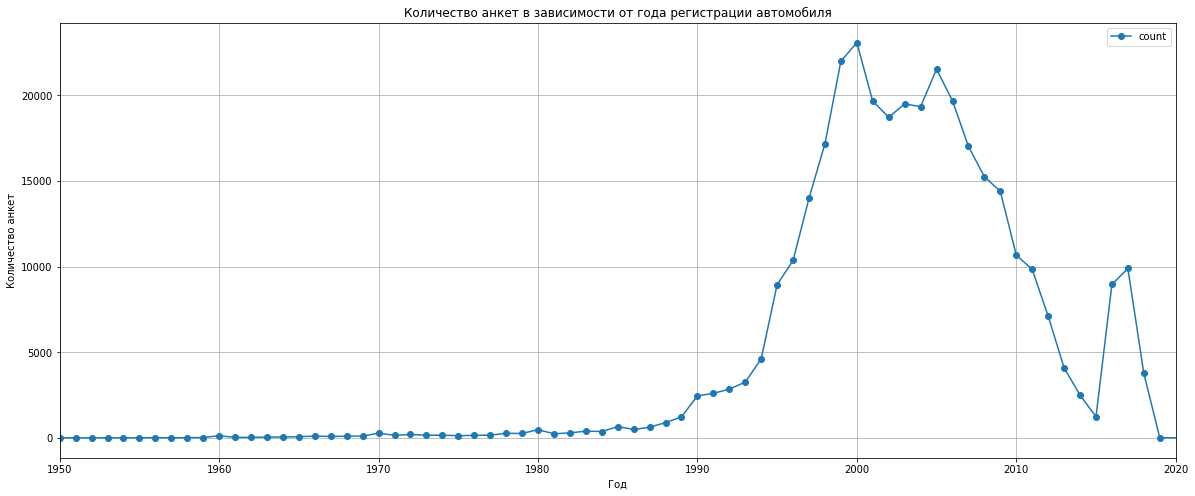

In [32]:
df_reg = df.groupby('registrationyear').agg({'price': ['count']}).reset_index(drop=False)
df_reg.columns = ['registrationyear', 'count']
df_reg.plot(x='registrationyear', y='count', style='o-', xlim=(1950, 2020), grid=True, figsize=(20, 8))
plt.xlabel('Год')
plt.ylabel('Количество анкет')
plt.title("Количество анкет в зависимости от года регистрации автомобиля")
plt.show()

In [33]:
print("Колличество объявлений с некорректным годом:",len(df.loc[df['registrationyear'] >= 2017]))

Колличество объявлений с некорректным годом: 13779


In [34]:
df=df.query('registrationyear < 2017')

In [35]:
df=df.query('not(registrationyear >= 2016 & registrationmonth > 4)')

In [36]:
print('Доля оставшихся данных от начального датасета:', round(df.shape[0]/len_df*100, 2))

Доля оставшихся данных от начального датасета: 91.81


In [37]:
#Также удалим объявления с годом регистрации авто ранее 1970 года.
df=df.query('registrationyear > 1969')

In [38]:
print('Доля оставшихся данных от начального датасета:', round(df.shape[0]/len_df*100, 2))

Доля оставшихся данных от начального датасета: 91.48


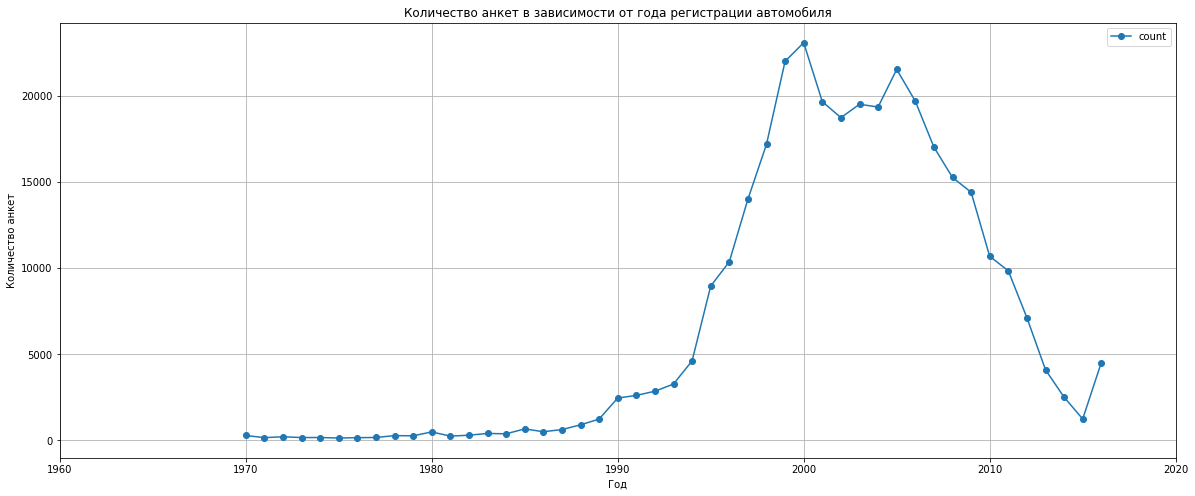

In [39]:
df_reg2 = df.groupby('registrationyear').agg({'price': ['count']}).reset_index(drop=False)
df_reg2.columns = ['registrationyear', 'count']
df_reg2.plot(x='registrationyear', y='count', style='o-', xlim=(1960, 2020), grid=True, figsize=(20, 8))
plt.xlabel('Год')
plt.ylabel('Количество анкет')
plt.title("Количество анкет в зависимости от года регистрации автомобиля")
plt.show()

In [40]:
df=df.reset_index(drop=True)

In [41]:
df['power'].describe()

count    324185.000000
mean        112.368231
std         181.257843
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

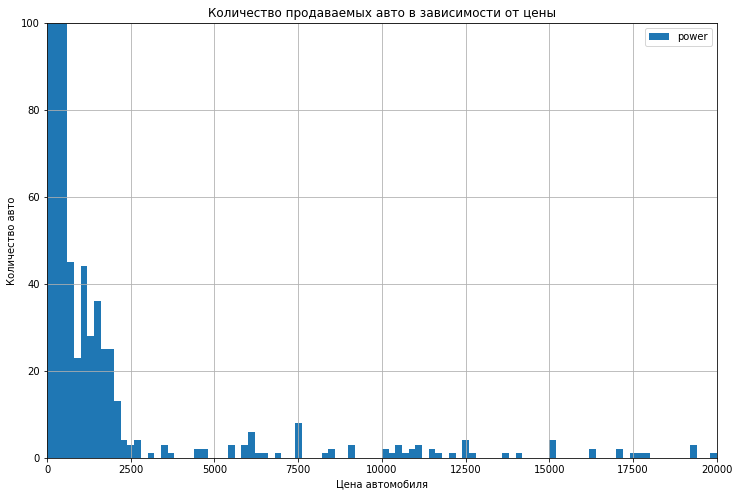

In [42]:
df.plot(y='power', kind='hist', bins=100, grid=True, figsize=(12, 8), ylim=(0, 100), xlim=(0, 20000))
plt.xlabel('Цена автомобиля')
plt.ylabel('Количество авто')
plt.title("Количество продаваемых авто в зависимости от цены")
plt.show()

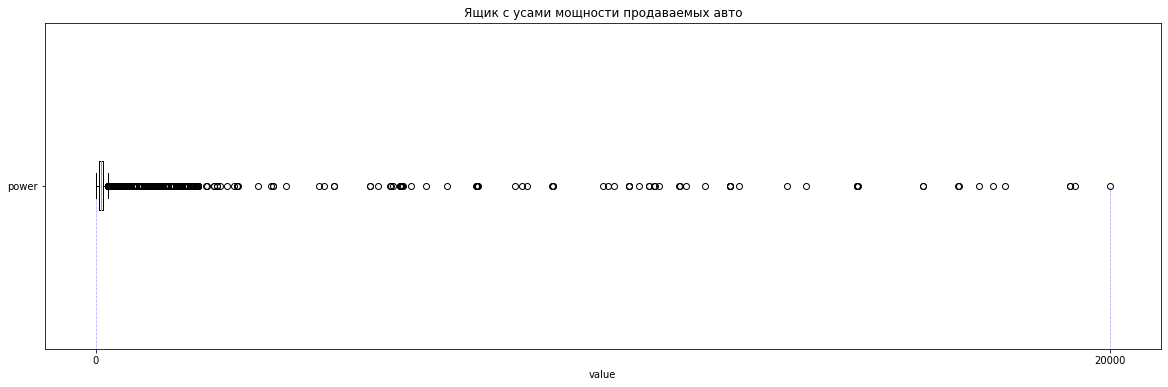

In [43]:
fig = plt.figure(1, figsize=(20, 6))
ax = fig.add_subplot(111)

ax.boxplot(df['power'], vert=False, manage_ticks=True)
ax.set_xlabel('value')
ax.set_yticks([1])
ax.set_yticklabels(['power'])

quantiles = np.quantile(df['power'], np.array([0, 1.00]))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(quantiles)
plt.title("Ящик с усами мощности продаваемых авто")
plt.show()

**Отмечаются аномально высокие значения мощности авто (более 1000 л.с.) и большое количество нулевых значений. Вероятно, из-за какой-то ошибки аномально высокие значений выгрузились без запятой. Нулевые значения оставим без изменений возможно продаваемые машины неисправны. Аномально высокие значения более 1000 и менне 10000 поделим на 10, а более 10000 - поделим на 100.**

In [44]:
display(df.query('power > 10000'))

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
23019,2016-03-28 19:57:39,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no,2016-03-28,0,36272,2016-04-07 02:47:02
41198,2016-04-07 07:36:38,15800,convertible,2014,auto,10218,fortwo,30000,3,petrol,smart,no,2016-04-06,0,81373,2016-04-07 07:36:38
52127,2016-04-01 21:55:58,1995,wagon,2002,manual,11530,focus,150000,1,petrol,ford,no,2016-04-01,0,35759,2016-04-05 14:44:36
57616,2016-03-27 18:47:59,2200,small,1999,manual,12012,polo,150000,3,petrol,volkswagen,no,2016-03-27,0,9526,2016-04-01 19:44:55
58535,2016-03-28 11:49:56,3250,sedan,2001,auto,17932,omega,150000,6,petrol,opel,no,2016-03-28,0,86641,2016-04-06 14:17:21
71219,2016-03-25 13:36:57,850,sedan,2000,manual,12510,astra,30000,10,other,opel,no,2016-03-25,0,23611,2016-03-31 20:45:39
77671,2016-03-28 10:49:33,1999,sedan,1991,auto,10912,other,150000,0,gasoline,mercedes_benz,no,2016-03-28,0,88069,2016-03-30 01:15:32
88267,2016-03-16 13:46:18,1380,convertible,2001,auto,10710,megane,150000,10,other,renault,no,2016-03-16,0,71282,2016-03-19 10:45:58
88465,2016-03-12 10:36:18,4700,bus,1997,manual,10522,transporter,150000,0,gasoline,volkswagen,no,2016-03-12,0,87437,2016-03-12 10:36:18
90313,2016-03-31 18:54:51,5500,wagon,2010,manual,11509,ceed,150000,9,other,kia,no,2016-03-31,0,15907,2016-04-06 13:15:34


In [45]:
def powers(power):
    if (power < 1000):
        return int(power)
    elif (power >= 1000) & (power < 10000):
        return int(power/10)
    elif (power >=10000):
        return int(power/100)
    
df['power'] = df['power'].apply(powers)

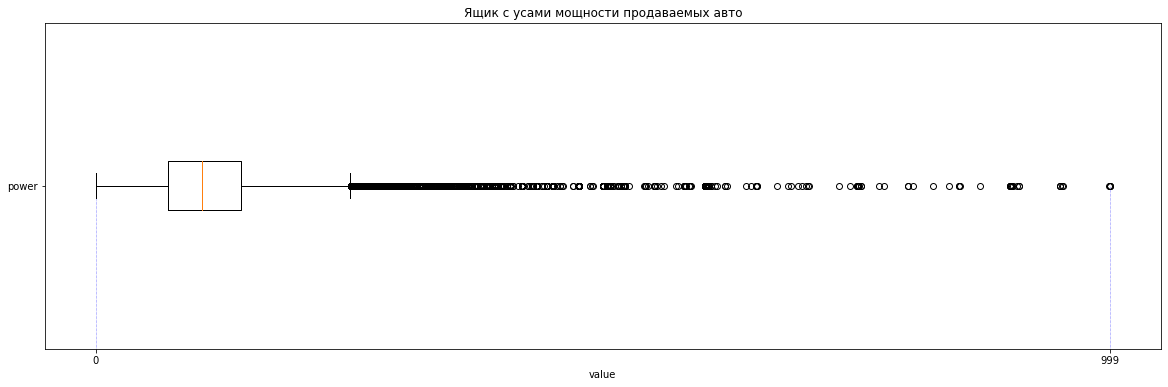

In [46]:
fig = plt.figure(1, figsize=(20, 6))
ax = fig.add_subplot(111)

ax.boxplot(df['power'], vert=False, manage_ticks=True)
ax.set_xlabel('value')
ax.set_yticks([1])
ax.set_yticklabels(['power'])

quantiles = np.quantile(df['power'], np.array([0, 1.00]))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(quantiles)
plt.title("Ящик с усами мощности продаваемых авто")
plt.show()

**Заменим нулевые значения мощности средним значением по бренду и модели авто.**

In [47]:
df.query('power == 0').head(5)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
27,2016-03-15 20:59:01,245,sedan,1994,manual,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
32,2016-03-28 17:50:15,1500,other,2016,manual,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
46,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,other,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32
47,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26,0,56759,2016-04-01 23:17:27


In [48]:
#заменим нулевые значения в 'power' на среднее значение по бренду и модели.
df['power'] = np.where(df['power'] == 0, df.groupby(['brand', 'model'])['power'].transform('mean'), df['power'])

In [49]:
df.query('power == 0')

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
214314,2016-03-30 11:39:08,3800,wagon,1978,manual,0.0,serie_1,30000,0,gasoline,land_rover,no,2016-03-30,0,49824,2016-03-30 11:39:08


**Удалил 1 оставшееся значение.**

In [50]:
df=df.query('power > 0')

**Ранее важные признаки сохранил в список important, оставим его в исходном датасете.**

In [51]:
df = df[important]

In [52]:
df.power.min()

1.0

In [53]:
df.duplicated().sum()

49679

In [55]:
df = df.drop_duplicates().reset_index(drop=True)

In [56]:
df.duplicated().sum()

0

In [82]:
print('Доля оставшихся данных от начального датасета:', round(df.shape[0]/len_df*100, 2))

Доля оставшихся данных от начального датасета: 77.46


**В результате анализа общей информации выявлено следующее:**
- В датасете присутствуют 354369 объектов, 15 признаков и 1 целевой признак price.
- более 10% пропущенных значений есть в признаках Repaired и VehicleType, до 10% - в признаках FuelType, Gearbox, Model. В остальных признаках пропусков нет.
- Доля объектов с хотябы одним пропущенным значением составляет почти 31%, что достаточно много.
- в данных присутствует 4 полных дубликата, которые необходимо удалить.
- В датасете присутствуют объявления о продаже авто созданные в период с марта 2014 года по апрель 2016 года.
- Коррелирующие признаки отсутствуют.


**В результате предобработки данных выполнено следующее:**
- Удалены объекты, в которых стоимость машин равно 0.
- В столбце 'vehicletype' пропуски заполнены значением 'other'.
- В столбце 'repaired' есть два значения да и нет, вероятно, у кого машина не была в ремонте просто не ставили значение в ячейку, поэтому пропущенные ячейки заполнены значением 'no'.
- В столбцах 'model' и 'fueltype' также есть значение 'other', им заполнены пропущенные значения.
- Пропуски в столбце 'gearbox' заполнены модой сгруппировав по брэнду и модели.
- Год регистрации начинается с 1000 года и заканчивается 9999 годом, что очень странно, поэтому удалены объекты с годом регистрации позже апреля 2016 года, так как это максимальное значение даты создания анкеты и удалены объекты с годом регистрации ранее 1970 года.
- Отмечаются аномально высокие значения мощности авто (более 1000 л.с.) и большое количество нулевых значений. Вероятно, из-за какой-то ошибки аномально высокие значений выгрузились без запятой. Нулевые значения обработаны средним по бренду и марке. Аномально высокие значения более 1000 и менее 10000 поделены на 10, а более 10000 - поделены на 100.
- Доля оставшихся данных от начального датасета: 77.5 %.
- В исходном датасете оставил признаки: 'price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model', 'kilometer', 'fueltype', 'brand', 'repaired'.

## Обучение моделей

**Подготовим выборки**

**Разделим датафрейм на признаки (X) и целевую переменную (y).**Ч

In [57]:
X = df.drop('price', axis=1)
y = df['price']

**Разделим данные на обучающую, валидационную и тестовую выборки.**

In [58]:
# разделяем на обучающую и тестовую выборки (60/40)
X_train, X_test, y_train, y_test  = train_test_split(X, 
                                                     y, 
                                                     test_size=0.4,
                                                     random_state=12345)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(164703, 9)
(164703,)
(109802, 9)
(109802,)


In [59]:
X_train

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
138269,sedan,1994,manual,193.000000,other,150000,petrol,bmw,no
108834,convertible,2003,manual,109.000000,2_reihe,125000,petrol,peugeot,no
246659,convertible,1994,manual,97.208227,golf,150000,petrol,volkswagen,no
127124,small,2005,auto,61.000000,fortwo,125000,petrol,smart,no
53215,small,2000,manual,69.000000,polo,30000,other,volkswagen,no
...,...,...,...,...,...,...,...,...,...
158838,sedan,1999,auto,125.000000,e_klasse,150000,gasoline,mercedes_benz,no
47873,sedan,2001,auto,224.000000,a8,150000,gasoline,audi,no
86398,wagon,1996,manual,101.000000,astra,150000,petrol,opel,yes
77285,bus,1989,manual,97.382647,transporter,20000,gasoline,volkswagen,yes


In [60]:
# разделяем тестовую выборку на валидационную и тестовую (50/50)
X_valid, X_test, y_valid, y_test  = train_test_split(X_test, 
                                                     y_test, 
                                                     test_size=0.5,                                                     
                                                     random_state=12345)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(54901, 9)
(54901,)
(54901, 9)
(54901,)


In [61]:
#сохраним выборки с незакодированными категориальными признаками 
#в отдельные переменные для дальнейшего использования в модели CatBoostRegressor
X_train_notcoded = X_train.copy()
X_valid_notcoded = X_valid.copy()
X_test_notcoded = X_test.copy()

**Выполним масштабирование.**

In [62]:
#Выполним масштабирование числовых переменных

numeric_X = ['registrationyear', 'power', 'kilometer']

scaler = StandardScaler()

X_train[numeric_X] = scaler.fit_transform(X_train[numeric_X])
X_valid[numeric_X] = scaler.transform(X_valid[numeric_X])
X_test[numeric_X] = scaler.transform(X_test[numeric_X])

In [63]:
#Выполним кодировку номинальных признаков
nominal_X = ['model', 'brand']

mee = ce.MEstimateEncoder(cols=nominal_X, m=5.0, random_state=12345)

X_train[nominal_X] = mee.fit_transform(X_train[nominal_X], y_train)
X_valid[nominal_X] = mee.transform(X_valid[nominal_X])
X_test[nominal_X] = mee.transform(X_test[nominal_X])

In [64]:
X_train[nominal_X].describe()

,model,brand
count,164703.000000,164703.000000
mean,4748.563262,4756.828664
std,2385.622171,1532.519199
min,834.087913,1088.113480
25%,3259.517847,3314.990284
50%,4054.482031,4904.448060
75%,5803.779730,6119.043161
max,16058.075488,11614.171556


In [65]:
#Видно, что значения признаков 'model' и 'brand' слишком большие, поэтому выполним их масштабирование
scaler = StandardScaler()

X_train[nominal_X] = scaler.fit_transform(X_train[nominal_X])
X_valid[nominal_X] = scaler.transform(X_valid[nominal_X])
X_test[nominal_X] = scaler.transform(X_test[nominal_X])

In [66]:
X_train_notcoded

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
138269,sedan,1994,manual,193.000000,other,150000,petrol,bmw,no
108834,convertible,2003,manual,109.000000,2_reihe,125000,petrol,peugeot,no
246659,convertible,1994,manual,97.208227,golf,150000,petrol,volkswagen,no
127124,small,2005,auto,61.000000,fortwo,125000,petrol,smart,no
53215,small,2000,manual,69.000000,polo,30000,other,volkswagen,no
...,...,...,...,...,...,...,...,...,...
158838,sedan,1999,auto,125.000000,e_klasse,150000,gasoline,mercedes_benz,no
47873,sedan,2001,auto,224.000000,a8,150000,gasoline,audi,no
86398,wagon,1996,manual,101.000000,astra,150000,petrol,opel,yes
77285,bus,1989,manual,97.382647,transporter,20000,gasoline,volkswagen,yes


In [67]:
# Выполним кодировку категориальных порядковых признаков
categorical_X = ['vehicletype', 'gearbox', 'fueltype', 'repaired']

transformer = make_column_transformer(
    (OneHotEncoder(sparse=False, drop='first'), categorical_X),
    remainder='passthrough')

transformed_train = transformer.fit_transform(X_train)
X_train = pd.DataFrame(transformed_train, columns=transformer.get_feature_names())

transformed_valid = transformer.transform(X_valid)
X_valid = pd.DataFrame(transformed_valid, columns=transformer.get_feature_names())

transformed_test = transformer.transform(X_test)
X_test = pd.DataFrame(transformed_test, columns=transformer.get_feature_names())

In [68]:
#Проверяем размеры выборок
print(X_train.shape)
print(X_train.columns)

print(X_valid.shape)
print(X_valid.columns)

print(X_test.shape)
print(X_test.columns)

(164703, 20)
Index(['onehotencoder__x0_convertible', 'onehotencoder__x0_coupe',
       'onehotencoder__x0_other', 'onehotencoder__x0_sedan',
       'onehotencoder__x0_small', 'onehotencoder__x0_suv',
       'onehotencoder__x0_wagon', 'onehotencoder__x1_manual',
       'onehotencoder__x2_electric', 'onehotencoder__x2_gasoline',
       'onehotencoder__x2_hybrid', 'onehotencoder__x2_lpg',
       'onehotencoder__x2_other', 'onehotencoder__x2_petrol',
       'onehotencoder__x3_yes', 'registrationyear', 'power', 'model',
       'kilometer', 'brand'],
      dtype='object')
(54901, 20)
Index(['onehotencoder__x0_convertible', 'onehotencoder__x0_coupe',
       'onehotencoder__x0_other', 'onehotencoder__x0_sedan',
       'onehotencoder__x0_small', 'onehotencoder__x0_suv',
       'onehotencoder__x0_wagon', 'onehotencoder__x1_manual',
       'onehotencoder__x2_electric', 'onehotencoder__x2_gasoline',
       'onehotencoder__x2_hybrid', 'onehotencoder__x2_lpg',
       'onehotencoder__x2_other', 'oneh

**Количество объектов соответствует тому, как разделили выборку изначально, при этом добавилось 11 дополнительных столбцов ввиду работы OneHotEncoder.**

In [69]:
#создадим функию для расчета RMSE
def rmse(test, predict):
    return mean_squared_error(test, predict, squared=False).round(0)

**2.1 Обучим модель линейной регрессии.**

In [70]:
%%time
start = time.time()

model_lin = LinearRegression()
model_lin.fit(X_train, y_train)

end = time.time()
fit_time_lin = round((end - start), 2)

start = time.time()

predictions_lin = model_lin.predict(X_valid)

end = time.time()
pred_time_lin = round((end - start), 2)

rmse_lin = rmse(y_valid, predictions_lin)
print('Квадратный корень из средней квадратичной ошибки RMSE для линейной регрессии:', rmse_lin)
print('Время обучения:', fit_time_lin)
print('Время предсказания:', pred_time_lin)

Квадратный корень из средней квадратичной ошибки RMSE для линейной регрессии: 2810.0
Время обучения: 0.19
Время предсказания: 0.19
CPU times: user 219 ms, sys: 204 ms, total: 423 ms
Wall time: 384 ms


    **2.2. Обучим модель случайного леса.**

In [71]:
%%time
#Обучим модель случайного леса
#определим наилучшие гиперпараметры и RMSE для лучшей модели случайного леса 

best_model_forest = None
best_est_forest = 0
best_depth_forest = 0
best_rmse_forest = 10000
for est in range(10, 51, 10):
    for depth in range(1, 10):
        model_forest = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(X_train, y_train)
        predictions_valid_forest = model_forest.predict(X_valid)
        result_forest = rmse(y_valid, predictions_valid_forest)
        if result_forest < best_rmse_forest:
            best_model_forest = model_forest
            best_est_forest = est
            best_depth_forest = depth
            best_rmse_forest = result_forest

print("Количество деревьев 'Estimators' лучшей модели:", best_est_forest)
print("Глубина 'Max_depth' лучшей модели:", best_depth_forest)
print('Квадратный корень из средней квадратичной ошибки RMSE для случайного леса:', best_rmse_forest)

Количество деревьев 'Estimators' лучшей модели: 20
Глубина 'Max_depth' лучшей модели: 9
Квадратный корень из средней квадратичной ошибки RMSE для случайного леса: 1956.0
CPU times: user 4min 56s, sys: 933 ms, total: 4min 57s
Wall time: 4min 57s


***Обучим модель случайного леса с лучшими гиперпараметрами.***

In [72]:
%%time
start = time.time()

model_forest = RandomForestRegressor(random_state=12345, 
                                      n_estimators=20, 
                                      max_depth=9)
model_forest.fit(X_train, y_train)

end = time.time()
fit_time_forest = round((end - start), 2)

start = time.time()

predictions_valid_forest = model_forest.predict(X_valid)

end = time.time()
pred_time_forest = round((end - start), 2)

result_forest = rmse(y_valid, predictions_valid_forest)
print('Квадратный корень из средней квадратичной ошибки RMSE для случайного леса:', result_forest)
print('Время обучения:', fit_time_forest)
print('Время предсказания:', pred_time_forest)

Квадратный корень из средней квадратичной ошибки RMSE для случайного леса: 1956.0
Время обучения: 6.1
Время предсказания: 0.09
CPU times: user 6.14 s, sys: 44 ms, total: 6.19 s
Wall time: 6.2 s


**2.3 Обучим модель CatBoostRegressor.**

In [73]:
parameters_cbr = {'learning_rate': np.logspace(-2, 0, 4),
                  'depth': range(10, 41, 10),
                  'n_estimators': range(10, 51, 10)}

In [74]:
category_X_notcoded = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

In [75]:
%%time

grid_cbr = GridSearchCV(CatBoostRegressor(loss_function='RMSE',
                                          silent=True,                                                                                 
                                          random_state=12345, 
                                          cat_features=category_X_notcoded),
                        parameters_cbr,
                        scoring='neg_mean_squared_error',
                        cv=3)
grid_cbr.fit(X_train_notcoded, y_train);

grid_cbr.best_params_

CPU times: user 2min 37s, sys: 1.57 s, total: 2min 38s
Wall time: 3min 34s


{'depth': 10, 'learning_rate': 0.21544346900318834, 'n_estimators': 50}

***Обучим модель CatBoostRegressor с лучшими гиперпараметрами.***

In [76]:
%%time
start = time.time()

model_cbr = grid_cbr.best_estimator_
# model_cbr = CatBoostRegressor(loss_function='RMSE',
#                               random_state=12345,
#                               cat_features=category_X_notcoded, 
#                               learning_rate=1, 
#                               depth=10, 
#                               n_estimators=50)

model_cbr.fit(X_train_notcoded, y_train)

end = time.time()
fit_time_cbr = round((end - start), 2)

start = time.time()

predictions_valid_cbr = model_cbr.predict(X_valid_notcoded)

end = time.time()
pred_time_cbr = round((end - start), 2)

result_cbr = rmse(y_valid, predictions_valid_cbr)
print('Квадратный корень из средней квадратичной ошибки RMSE для CatBoostRegressor:', result_cbr)
print('Время обучения:', fit_time_cbr)
print('Время предсказания:', pred_time_cbr)

Квадратный корень из средней квадратичной ошибки RMSE для CatBoostRegressor: 1719.0
Время обучения: 5.17
Время предсказания: 0.08
CPU times: user 4.66 s, sys: 56.1 ms, total: 4.72 s
Wall time: 5.26 s


**2.4 Обучим модель LGBMRegressor.**

In [77]:
parameters_lgbm = {'num_leaves': range(20, 41, 10),
                   'max_depth': range(10, 41, 10),
                   'n_estimators': range(10, 51, 10)}

In [78]:
%%time

grid_lgbm = GridSearchCV(LGBMRegressor(random_state=12345), parameters_lgbm, scoring='neg_root_mean_squared_error', cv=3)
grid_lgbm.fit(X_train, y_train)

grid_lgbm.best_params_

CPU times: user 4min 24s, sys: 4.21 s, total: 4min 28s
Wall time: 4min 30s


{'max_depth': 20, 'n_estimators': 50, 'num_leaves': 40}

***Обучим модель LGBMRegressor с лучшими гиперпараметрами.***

In [79]:
%%time
start = time.time()

model_lgbm = grid_lgbm.best_estimator_
# model_lgbm = LGBMRegressor(max_depth=40, n_estimators=50, num_leaves=40)
model_lgbm.fit(X_train, y_train)

end = time.time()
fit_time_lgbm = round((end - start), 2)

start = time.time()

predictions_valid_lgbm = model_lgbm.predict(X_valid)

end = time.time()
pred_time_lgbm = round((end - start), 2)

result_lgbm = rmse(y_valid, predictions_valid_lgbm)
print('Квадратный корень из средней квадратичной ошибки RMSE для LGBMRegressor :', result_lgbm)
print('Время обучения:', fit_time_lgbm)
print('Время предсказания:', pred_time_lgbm)

Квадратный корень из средней квадратичной ошибки RMSE для LGBMRegressor : 1772.0
Время обучения: 2.4
Время предсказания: 0.3
CPU times: user 2.66 s, sys: 30.7 ms, total: 2.69 s
Wall time: 2.7 s


## Анализ моделей

In [80]:
#занесем результаты в отдельный датафрейм
model_type = ['Linear Regression', 'Random Forest Regressor', 'CatBoostRegressor', 'LGBMRegressor']
RMSE = [rmse_lin, result_forest, result_cbr, result_lgbm]
fit_time = [fit_time_lin, fit_time_forest, fit_time_cbr, fit_time_lgbm]
pred_time = [pred_time_lin, pred_time_forest, pred_time_cbr, pred_time_lgbm]


result = pd.DataFrame({'Model Type': model_type,
                           'RMSE': RMSE,
                           'fit_time': fit_time,
                           'pred_time': pred_time,                           
                         })

result

,Model Type,RMSE,fit_time,pred_time
0,Linear Regression,2810.0,0.19,0.19
1,Random Forest Regressor,1956.0,6.10,0.09
2,CatBoostRegressor,1719.0,5.17,0.08
3,LGBMRegressor,1772.0,2.40,0.30


**Наименьшее значение RMSE получилось у модели CatBoostRegressor, однако у нее и самое большое время обучения, если заказчик может немного пренебречь качеством предсказаний модели, то наилучшей моделей будет являться LGBMRegressor, у которой качество практически такое же как у CatBoostRegressor, но при этом она почти в 2 раза быстрее. Модели Linear Regression и Random Forest Regressor по качеству значительно хуже.**

**Протестируем модель LGBMRegressor на тестовой выборке.**

In [81]:
%%time

predictions_test_lgbm = model_lgbm.predict(X_test)

result_lgbm = rmse(y_test, predictions_test_lgbm)
print('Квадратный корень из средней квадратичной ошибки RMSE для LGBMRegressor на тестовой выборке:', result_lgbm)

Квадратный корень из средней квадратичной ошибки RMSE для LGBMRegressor на тестовой выборке: 1749.0
CPU times: user 270 ms, sys: 3.45 ms, total: 274 ms
Wall time: 191 ms


**RMSE для LGBMRegressor на тестовой выборке составил 1749, что меньше необходимого значения (2500).**

## Общий вывод

**В результате анализа общей информации выявлено следующее:**
- В датасете присутствуют 354369 объектов, 15 признаков и 1 целевой признак price.
- более 10% пропущенных значений есть в признаках Repaired и VehicleType, до 10% - в признаках FuelType, Gearbox, Model. В остальных признаках пропусков нет.
- Доля объектов с хотябы одним пропущенным значением составляет почти 31%, что достаточно много.
- в данных присутствует 4 полных дубликата, которые необходимо удалить.
- В датасете присутствуют объявления о продаже авто созданные в период с марта 2014 года по апрель 2016 года.
- Коррелирующие признаки отсутствуют.

**В результате предобработки данных выполнено следующее:**
- Удалены объекты, в которых стоимость машин равно 0.
- В столбце 'vehicletype' пропуски заполнены значением 'other'.
- В столбце 'repaired' есть два значения да и нет, вероятно, у кого машина не была в ремонте просто не ставили значение в ячейку, поэтому пропущенные ячейки заполнены значением 'no'.
- В столбцах 'model' и 'fueltype' также есть значение 'other', им заполнены пропущенные значения.
- Пропуски в столбце 'gearbox' заполнены модой сгруппировав по брэнду и модели.
- Год регистрации начинается с 1000 года и заканчивается 9999 годом, что очень странно, поэтому удалены объекты с годом регистрации позже апреля 2016 года, так как это максимальное значение даты создания анкеты и удалены объекты с годом регистрации ранее 1970 года.
- Отмечаются аномально высокие значения мощности авто (более 1000 л.с.) и большое количество нулевых значений. Вероятно, из-за какой-то ошибки аномально высокие значений выгрузились без запятой. Нулевые значения обработаны средним по бренду и марке. Аномально высокие значения более 1000 и менее 10000 поделены на 10, а более 10000 - поделены на 100.
- Доля оставшихся данных от начального датасета: 77.5 %.
- В исходном датасете оставил признаки: 'price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model', 'kilometer', 'fueltype', 'brand', 'repaired'.


**Модели:**

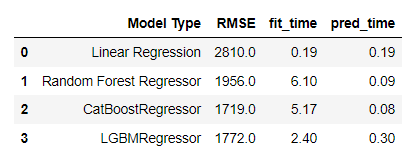

- В результате обучения моделей наилучшей оказалась модель LGBMRegressor со следующими гиперпараметрами: 
    количество деревьев 'Estimators' лучшей модели - 50, глубина 'Max_depth' лучшей модели - 20, количество листьев 'num_leaves' - 40.
- Она почти в 2 раза быстрее CatBoostRegressor, но при этом качество почти не отличается.
- Финальная оценка RMSE на тестовой выборке составила 1749, что меньше необходимого значения (2500).

**Желание заказчика удовлетворено.**